# 3D image matching with LDDMM

## import required libraries

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.ion() # for drawing in real time
import nibabel as nib
import tensorflow as tf

In [2]:
# datatypes
# I have a feeling that my problems were due to not enough bits
dtype = tf.float32
# ffts do not work with 64 bit!
idtype = tf.int64 # for integers

## load images to register

In [3]:
# input image filenames here
# we will deform the atlas to match the target
atlas_image_fname = 'Adt27-55_02_Adt27-55_02_MNI.img'
target_image_fname = 'Adt27-55_03_Adt27-55_03_MNI.img'

In [4]:
# load them
fnames = [atlas_image_fname,target_image_fname]
img = [nib.load(fname) for fname in fnames]

In [5]:
# get info about domains
# we assume for this example that we have the same voxel size and same voxel spacing
if '.img' == atlas_image_fname[-4:]:    
    nx = img[0].header['dim'][1:4]
    dx = img[0].header['pixdim'][1:4]
else:
    # I'm only working with analyze for now
    raise ValueError('Only Analyze images supported for now')
x = [np.arange(nxi)*dxi for nxi,dxi in zip(nx,dx)]

In [6]:
# get the images, note they also include a fourth axis for time that I don't want
I = img[0].get_data()[:,:,:,0]
J = img[1].get_data()[:,:,:,0]

In [7]:
# simple function for drawing 3 slices
def draw_slices(x,I,axlist,**kwargs):
    ''' Draw three slices through the middle of an image'''
    h0 = axlist[0].imshow(np.squeeze(I[:,:,I.shape[2]//2]),**kwargs)
    h1 = axlist[1].imshow(np.squeeze(I[:,I.shape[1]//2,:]),**kwargs)
    h2 = axlist[2].imshow(np.squeeze(I[I.shape[0]//2,:,:]),**kwargs)
    return [h0,h1,h2]

<IPython.core.display.Javascript object>


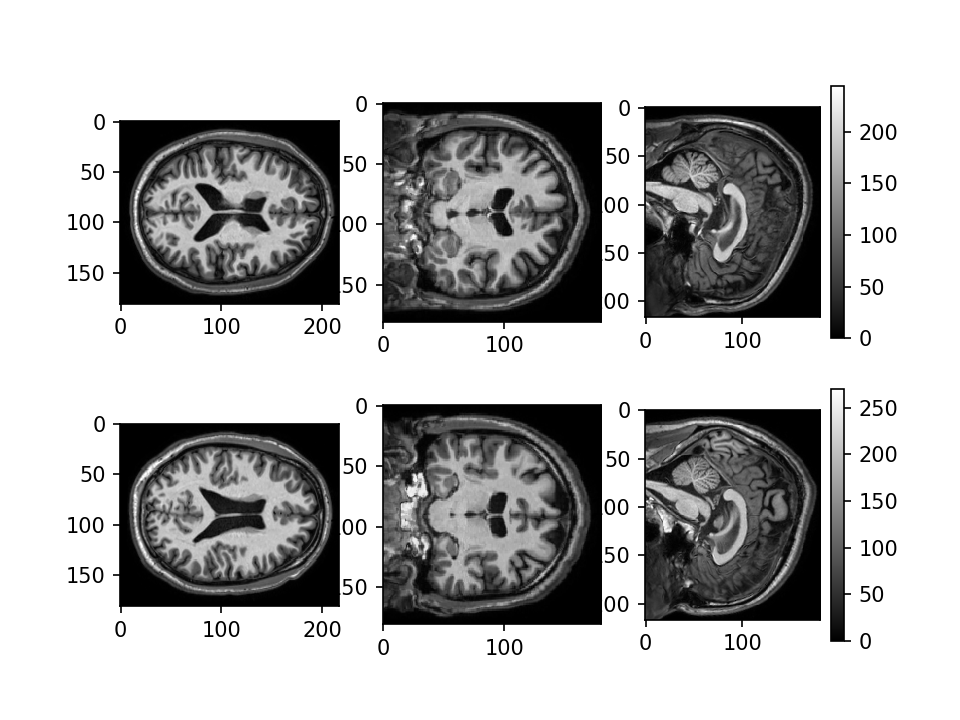

In [8]:
# draw my images
f,ax = plt.subplots(2,3)
h = draw_slices(x,I,ax[0],aspect='equal',cmap='gray')
plt.colorbar(mappable=h[-1],ax=ax[0][-1])
h = draw_slices(x,J,ax[1],aspect='equal',cmap='gray')
plt.colorbar(mappable=h[-1],ax=ax[1][-1])

## Now we need to define a linear interpolation function in tensorflow for 3d data

In [9]:
def interp3(x0,x1,x2,I,phi0,phi1,phi2):
    ''' 
    Linear interpolation
    Interpolate a 3D tensorflow image I
    with voxels corresponding to locations in x0, x1, x2 (1d arrays)
    at the points phi0, phi1, phi2 (3d arrays)
    '''
    # get the size
    dx = [x0[1]-x0[0], x1[1]-x1[0], x2[1]-x2[0]]
    nx = [len(x0), len(x1), len(x2)]
    #convert to index
    phi0_index = (phi0 - x0[0])/dx[0]
    phi1_index = (phi1 - x1[0])/dx[1]
    phi2_index = (phi2 - x2[0])/dx[2]
    # take the floor to get integers
    phi0_index_floor = tf.floor(phi0_index)
    phi1_index_floor = tf.floor(phi1_index)
    phi2_index_floor = tf.floor(phi2_index)
    # get the fraction to the next pixel
    phi0_p = phi0_index - phi0_index_floor
    phi1_p = phi1_index - phi1_index_floor
    phi2_p = phi2_index - phi2_index_floor
    # get the next samples
    phi0_index_floor_1 = phi0_index_floor+1
    phi1_index_floor_1 = phi1_index_floor+1
    phi2_index_floor_1 = phi2_index_floor+1
    # and apply boundary conditions
    phi0_index_floor = tf.minimum(phi0_index_floor,nx[0]-1)
    phi0_index_floor = tf.maximum(phi0_index_floor,0)
    phi0_index_floor_1 = tf.minimum(phi0_index_floor_1,nx[0]-1)
    phi0_index_floor_1 = tf.maximum(phi0_index_floor_1,0)
    phi1_index_floor = tf.minimum(phi1_index_floor,nx[1]-1)
    phi1_index_floor = tf.maximum(phi1_index_floor,0)
    phi1_index_floor_1 = tf.minimum(phi1_index_floor_1,nx[1]-1)
    phi1_index_floor_1 = tf.maximum(phi1_index_floor_1,0)
    phi2_index_floor = tf.minimum(phi2_index_floor,nx[2]-1)
    phi2_index_floor = tf.maximum(phi2_index_floor,0)
    phi2_index_floor_1 = tf.minimum(phi2_index_floor_1,nx[2]-1)
    phi2_index_floor_1 = tf.maximum(phi2_index_floor_1,0)
    # then we will need to vectorize everything to use scalar indices
    phi0_index_floor_flat = tf.reshape(phi0_index_floor,[-1])
    phi0_index_floor_flat_1 = tf.reshape(phi0_index_floor_1,[-1])
    phi1_index_floor_flat = tf.reshape(phi1_index_floor,[-1])
    phi1_index_floor_flat_1 = tf.reshape(phi1_index_floor_1,[-1])
    phi2_index_floor_flat = tf.reshape(phi2_index_floor,[-1])
    phi2_index_floor_flat_1 = tf.reshape(phi2_index_floor_1,[-1])
    I_flat = tf.reshape(I,[-1])
    # indices recall that the LAST INDEX IS CONTIGUOUS
    phi_index_floor_flat_000 = nx[2]*nx[1]*phi0_index_floor_flat + nx[2]*phi1_index_floor_flat + phi2_index_floor_flat
    phi_index_floor_flat_001 = nx[2]*nx[1]*phi0_index_floor_flat + nx[2]*phi1_index_floor_flat + phi2_index_floor_flat_1
    phi_index_floor_flat_010 = nx[2]*nx[1]*phi0_index_floor_flat + nx[2]*phi1_index_floor_flat_1 + phi2_index_floor_flat
    phi_index_floor_flat_011 = nx[2]*nx[1]*phi0_index_floor_flat + nx[2]*phi1_index_floor_flat_1 + phi2_index_floor_flat_1
    phi_index_floor_flat_100 = nx[2]*nx[1]*phi0_index_floor_flat_1 + nx[2]*phi1_index_floor_flat + phi2_index_floor_flat
    phi_index_floor_flat_101 = nx[2]*nx[1]*phi0_index_floor_flat_1 + nx[2]*phi1_index_floor_flat + phi2_index_floor_flat_1
    phi_index_floor_flat_110 = nx[2]*nx[1]*phi0_index_floor_flat_1 + nx[2]*phi1_index_floor_flat_1 + phi2_index_floor_flat
    phi_index_floor_flat_111 = nx[2]*nx[1]*phi0_index_floor_flat_1 + nx[2]*phi1_index_floor_flat_1 + phi2_index_floor_flat_1
    
    # now slice the image
    I000_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_000, dtype=idtype))
    I001_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_001, dtype=idtype))
    I010_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_010, dtype=idtype))
    I011_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_011, dtype=idtype))
    I100_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_100, dtype=idtype))
    I101_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_101, dtype=idtype))
    I110_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_110, dtype=idtype))
    I111_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_111, dtype=idtype))
    
    # reshape it
    I000 = tf.reshape(I000_flat,nx)
    I001 = tf.reshape(I001_flat,nx)
    I010 = tf.reshape(I010_flat,nx)
    I011 = tf.reshape(I011_flat,nx)
    I100 = tf.reshape(I100_flat,nx)
    I101 = tf.reshape(I101_flat,nx)
    I110 = tf.reshape(I110_flat,nx)
    I111 = tf.reshape(I111_flat,nx)

    # combine them!
    Il = I000*(1.0-phi0_p)*(1.0-phi1_p)*(1.0-phi2_p)\
        + I001*(1.0-phi0_p)*(1.0-phi1_p)*(    phi2_p)\
        + I010*(1.0-phi0_p)*(    phi1_p)*(1.0-phi2_p)\
        + I011*(1.0-phi0_p)*(    phi1_p)*(    phi2_p)\
        + I100*(    phi0_p)*(1.0-phi1_p)*(1.0-phi2_p)\
        + I101*(    phi0_p)*(1.0-phi1_p)*(    phi2_p)\
        + I110*(    phi0_p)*(    phi1_p)*(1.0-phi2_p)\
        + I111*(    phi0_p)*(    phi1_p)*(    phi2_p)
    return Il

<IPython.core.display.Javascript object>


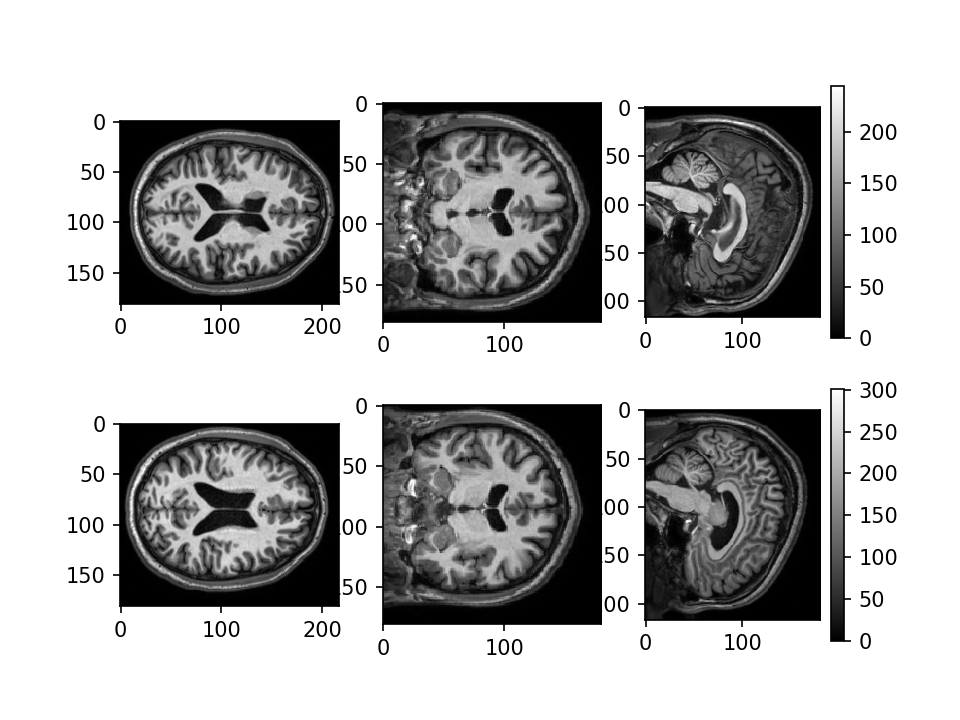

In [10]:
do_interp_test = True
if do_interp_test:
    # a quick test
    X0,X1,X2 = np.meshgrid(x[0],x[1],x[2],indexing='ij')
    X0tf = tf.constant(X0,dtype=dtype)
    X1tf = tf.constant(X1,dtype=dtype)
    X2tf = tf.constant(X2,dtype=dtype)
    Itf = tf.constant(I,dtype=dtype)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        Id = interp3(x[0],x[1],x[2],Itf,X0tf+5,X1tf+5,X2tf+5)
        Idnp = Id.eval()
    f,ax = plt.subplots(2,3)
    h = draw_slices(x,I,ax[0],aspect='equal',cmap='gray')
    plt.colorbar(mappable=h[-1],ax=ax[0][-1])
    h = draw_slices(x,Idnp,ax[1],aspect='equal',cmap='gray')
    plt.colorbar(mappable=h[-1],ax=ax[1][-1])

## and we need a gradient function

In [11]:
def grad3(I,dx):
    #I_0 = (tf.manip.roll(I,shift=-1,axis=0) - tf.manip.roll(I,shift=1,axis=0))/2.0/dx[0]
    #I_1 = (tf.manip.roll(I,shift=-1,axis=1) - tf.manip.roll(I,shift=1,axis=1))/2.0/dx[1]
    #I_2 = (tf.manip.roll(I,shift=-1,axis=2) - tf.manip.roll(I,shift=1,axis=2))/2.0/dx[2]
    
    #out[0,:] = out[1,:]-out[0,:] # this doesn't work in tensorflow
    # generally you cannot assign to a tensor
    # problems with energy calculations are due to this gradient function
    
    # in particular the determinant of jacobian part which is very much noncircular
    # this leads to discontinuity which becomes very large regularization energy
    # enforcing boundary conditions is essential
    I_0_m = (I[1,:,:] - I[0,:,:])/dx[0]
    I_0_p = (I[-1,:,:] - I[-2,:,:])/dx[0]
    I_0_0 = (I[2:,:,:]-I[:-2,:,:])/2.0/dx[0]
    I_0 = tf.concat([I_0_m[None,:,:], I_0_0, I_0_p[None,:,:]], axis=0)
    I_1_m = (I[:,1,:] - I[:,0,:])/dx[1]
    I_1_p = (I[:,-1,:] - I[:,-2,:])/dx[1]
    I_1_0 = (I[:,2:,:]-I[:,:-2,:])/2.0/dx[1]
    I_1 = tf.concat([I_1_m[:,None,:], I_1_0, I_1_p[:,None,:]], axis=1)
    I_2_m = (I[:,:,1] - I[:,:,0])/dx[2]
    I_2_p = (I[:,:,-1] - I[:,:,-2])/dx[2]
    I_2_0 = (I[:,:,2:]-I[:,:,:-2])/2.0/dx[2]
    I_2 = tf.concat([I_2_m[:,:,None], I_2_0, I_2_p[:,:,None]], axis=2)
    return I_0, I_1, I_2

<IPython.core.display.Javascript object>


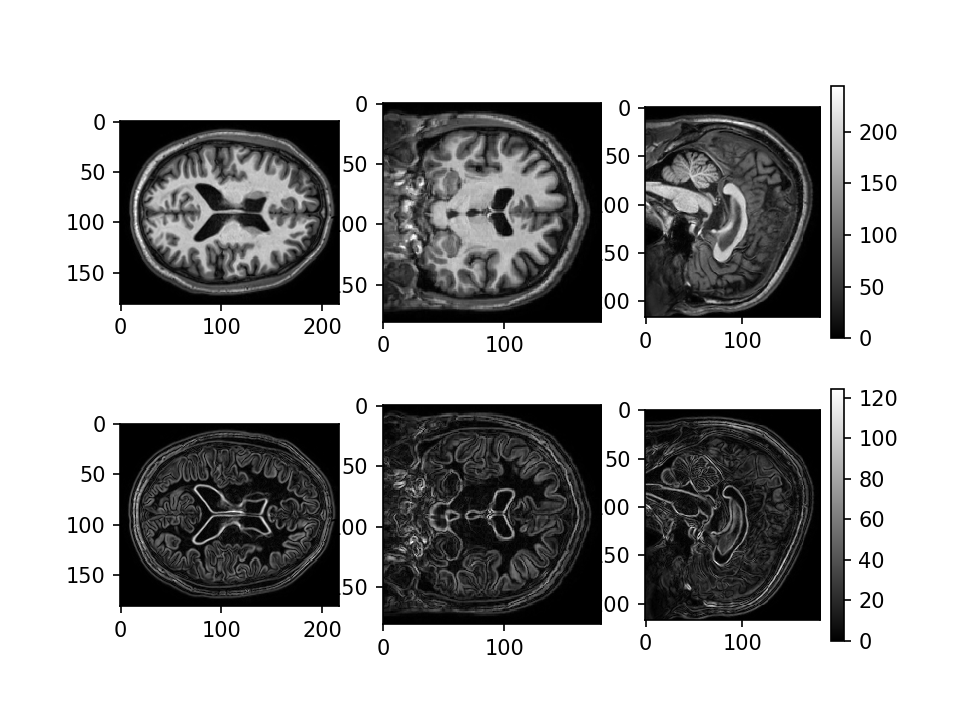

In [12]:
do_grad_test = True
if do_grad_test:
    # a quick test    
    Itf = tf.constant(I,dtype=dtype)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        I_0,I_1,I_2 = grad3(Itf,dx)
        Ishow = tf.sqrt(I_0**2 + I_1**2 + I_2**2)
        Ishownp = Ishow.eval()
    f,ax = plt.subplots(2,3)
    h = draw_slices(x,I,ax[0],aspect='equal',cmap='gray')
    plt.colorbar(mappable=h[-1],ax=ax[0][-1])
    h = draw_slices(x,Ishownp,ax[1],aspect='equal',cmap='gray')
    plt.colorbar(mappable=h[-1],ax=ax[1][-1])

## now we set some parameters


In [13]:
# gradient descent stepsize this will be a placeholder
# each time we will take a gradient descent step
# we may want to change it from time to time
epsilon = 1e-1
#epsilon = 5e-2
epsilonph = tf.placeholder(dtype, shape=()) 
niter = 20 # number of optimization iterations

# flow parameters
nt = 5 # number of timesteps
dt = 1.0/nt # increment in time for each step
alpha = dx[0]*2.0 # spatial scale of smoothing operator
power = 2.0 # power of identity - alpha*Laplacian

# cost parameters
sigmaM = (np.max(J) - np.min(J))*0.1 # matching cost standard deviation, smaller means larger cost
sigmaM = 1e1
sigmaR = 1e0 # regularization cost standard deviation
# lets reduce the reg cost a bit
#sigmaR = 1e1
sigmaM2 = sigmaM**2
sigmaR2 = sigmaR**2



## build a Fourier domain and differential operators

<IPython.core.display.Javascript object>


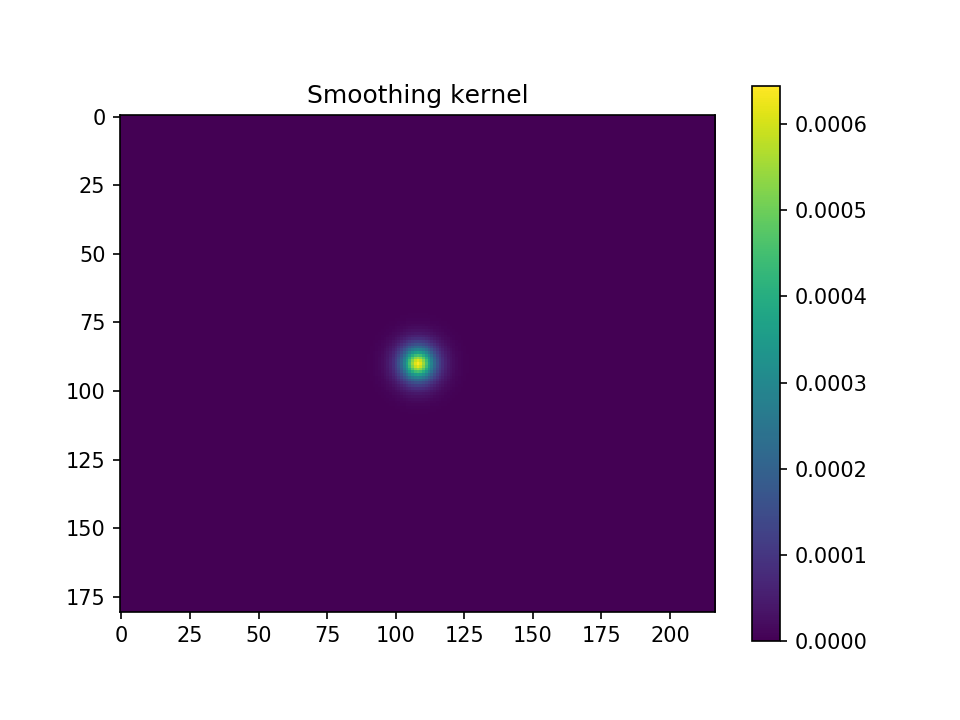

Text(0.5,1,'Smoothing kernel')

In [14]:
f0 = np.arange(nx[0])/dx[0]/nx[0]
f1 = np.arange(nx[1])/dx[1]/nx[1]
f2 = np.arange(nx[2])/dx[2]/nx[2]
F0,F1,F2 = np.meshgrid(f0, f1, f2, indexing='ij')
# identity minus laplacian, in fourier domain
# AI[i,j] = I[i,j] - alpha^2( (I[i+1,j] - 2I[i,j] + I[i-1,j])/dx^2 + (I[i,j+1] - 2I[i,j] + I[i,j-1])/dy^2  )
Lhat = (1.0 - alpha**2*( (-2.0 + 2.0*np.cos(2.0*np.pi*dx[0]*F0))/dx[0]**2 
    + (-2.0 + 2.0*np.cos(2.0*np.pi*dx[1]*F1))/dx[1]**2
    + (-2.0 + 2.0*np.cos(2.0*np.pi*dx[2]*F2))/dx[2]**2 ) )**power
# for real ffts we only half of this, TODO
LLhat = Lhat**2
Khat = 1.0/LLhat
K = np.real(np.fft.ifftn(Khat))
# convert to tensorflow
Khattf = tf.complex(tf.constant(Khat,dtype=dtype),tf.zeros((1),dtype=dtype))
# khat will multiply gradhat so it needs to be complex

#LLhattf = tf.complex(tf.constant(LLhat,dtype=dtype),0.)
LLhattf = tf.constant(LLhat,dtype=dtype)
# LL will multiply abs(v)**2 which is real, so it should just be a float
plt.figure()
plt.imshow(np.fft.fftshift(K[:,:,0]),aspect='equal')
plt.colorbar()
plt.title('Smoothing kernel')

Tensor("Const_7:0", shape=(181, 217, 181), dtype=float32)


<IPython.core.display.Javascript object>


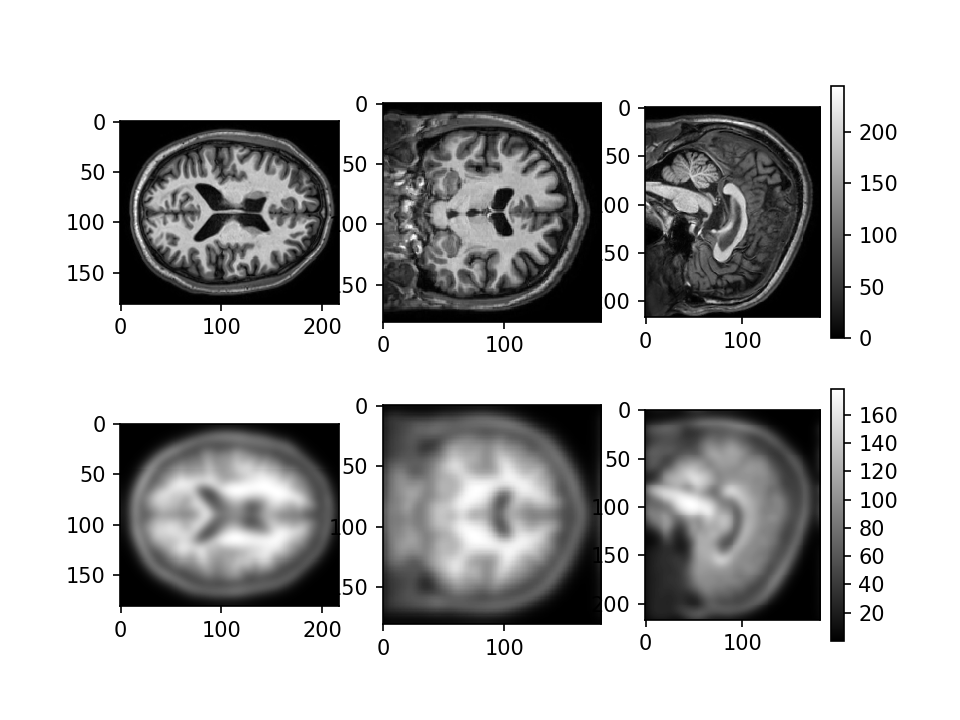

In [15]:
do_blur_test = True
if do_blur_test:
    # a quick test    
    Itf = tf.constant(I,dtype=dtype)
    print(Itf)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        Ihat = tf.fft3d(tf.complex(Itf,tf.zeros((1),dtype=dtype)))
        Ibhat = Ihat*Khattf
        Ib = tf.real(tf.ifft3d(Ibhat))
        Ibnp = Ib.eval()
    f,ax = plt.subplots(2,3)
    h = draw_slices(x,I,ax[0],aspect='equal',cmap='gray')
    plt.colorbar(mappable=h[-1],ax=ax[0][-1])
    h = draw_slices(x,Ibnp,ax[1],aspect='equal',cmap='gray')
    plt.colorbar(mappable=h[-1],ax=ax[1][-1])

In [16]:
do_normalization_test = True
if do_normalization_test:
    # I'm testing the sum of squares
    Itf = tf.constant(I,dtype=dtype)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        Ihat = tf.fft3d(tf.complex(Itf,tf.zeros([1],dtype=dtype)))
        Ibhat = Ihat*tf.complex(LLhattf,tf.zeros([1],dtype=dtype))
        Ib = tf.real(tf.ifft3d(Ibhat))
        ERfft = tf.reduce_sum(tf.abs(Ihat)**2*tf.real(LLhattf))/nx[0]/nx[1]/nx[2]
        ER = tf.reduce_sum(Itf*Ib)
        ERfft64 = tf.reduce_sum(tf.cast(tf.abs(Ihat)**2*tf.real(LLhattf),dtype=tf.float64 ))/nx[0]/nx[1]/nx[2]
        ER64 = tf.reduce_sum(tf.cast(Itf*Ib,dtype=tf.float64))
        # these two should give the same thing
        ERfft_,ER_,ERfft64_,ER64_ = sess.run([ERfft,ER,ERfft64,ER64])
        print(ERfft_,ER_,ERfft64_,ER64_)
        # note about normalization
        # converting to 64 bit before accumulating is a good idea
        # the method of suming in fourier domain then dividing seems to give the most inconsistent results in 32 bits


27341017000000.0 27344522000000.0 27344573393435.97 27344581675153.38


## initialize my optimization variables

Each iteration there will be an old version and a new version


In [17]:
# NOTE this cell can only be run once
# if you run it again it will generate errors
vt0 = tf.get_variable('vt0',shape=[nx[0],nx[1],nx[2],nt],dtype=dtype,trainable=False,initializer=tf.zeros_initializer())
vt1 = tf.get_variable('vt1',shape=[nx[0],nx[1],nx[2],nt],dtype=dtype,trainable=False,initializer=tf.zeros_initializer())
vt2 = tf.get_variable('vt2',shape=[nx[0],nx[1],nx[2],nt],dtype=dtype,trainable=False,initializer=tf.zeros_initializer())

vt0new = tf.get_variable('vt0new',shape=[nx[0],nx[1],nx[2],nt],dtype=dtype,trainable=False,initializer=tf.zeros_initializer())
vt1new = tf.get_variable('vt1new',shape=[nx[0],nx[1],nx[2],nt],dtype=dtype,trainable=False,initializer=tf.zeros_initializer())
vt2new = tf.get_variable('vt2new',shape=[nx[0],nx[1],nx[2],nt],dtype=dtype,trainable=False,initializer=tf.zeros_initializer())

## Implement the tensorflow graph for one iteration of gradient descent

In [18]:
# initialize some variables
Itf = tf.constant(I,dtype=dtype)
Jtf = tf.constant(J,dtype=dtype)
x0=x[0]
x1=x[1]
x2=x[2]
X0,X1,X2 = np.meshgrid(x0,x1,x2,indexing='ij')
X0tf = tf.constant(X0,dtype=dtype)
X1tf = tf.constant(X1,dtype=dtype)
X2tf = tf.constant(X2,dtype=dtype)

In [19]:
# flow forwards
It = [Itf]
phiinv0 = X0tf
phiinv1 = X1tf
phiinv2 = X2tf
#ER = 0.0 # I think maybe there's a problem with this
# I'm pretty sure now there wasn't a problem with that
# I don't know why I'm not getting the reg energy to work out properly, it seems way too big
# I thought maybe the issue was related to precision
# I see that the precision is not great
# but we're talking 1 part in 100000, not huge effects like I'm seeing
ERt = []
for t in range(nt):
    # slice the velocity for convenience
    v0 = vt0[:,:,:,t]
    v1 = vt1[:,:,:,t]
    v2 = vt2[:,:,:,t]
    
    # points to sample at for updating diffeomorphisms
    X0s = X0tf - v0*dt
    X1s = X1tf - v1*dt
    X2s = X2tf - v2*dt
    
    # update diffeomorphism with nice boundary conditions
    phiinv0 = interp3(x0,x1,x2,phiinv0-X0tf,X0s,X1s,X2s)+X0s
    phiinv1 = interp3(x0,x1,x2,phiinv1-X1tf,X0s,X1s,X2s)+X1s
    phiinv2 = interp3(x0,x1,x2,phiinv2-X2tf,X0s,X1s,X2s)+X2s
    
    # deform the image
    It.append(interp3(x0,x1,x2,Itf,phiinv0,phiinv1,phiinv2))
    
    # get regularization energy
    # this is probably the fastest way to compute energy, note the normalizer 1/(number of elemetns)
    v0hat = tf.fft3d(tf.complex(v0,0.0))
    v1hat = tf.fft3d(tf.complex(v1,0.0))
    v2hat = tf.fft3d(tf.complex(v2,0.0))
    #ER_ = tf.reduce_sum( ( tf.pow(tf.abs(v0hat),2) + tf.pow(tf.abs(v1hat),2) + tf.pow(tf.abs(v2hat),2) ) * LLhattf )
    ER_ = tf.reduce_mean(tf.cast( ( tf.pow(tf.abs(v0hat),2) 
                                  + tf.pow(tf.abs(v1hat),2) 
                                  + tf.pow(tf.abs(v2hat),2) ) * LLhattf , dtype=tf.float64) )
    if t == 0:
        ER0 = ER_
    ERt.append(ER_)
    # the energy doesn't seem to be working out right
    # let's try more explicit
    #p0 = tf.real(tf.ifft3d(v0hat*tf.cast(LLhattf,tf.complex64)))
    #p1 = tf.real(tf.ifft3d(v1hat*tf.cast(LLhattf,tf.complex64)))
    #p2 = tf.real(tf.ifft3d(v2hat*tf.cast(LLhattf,tf.complex64)))
    #ER = ER + tf.reduce_sum(v0*p0 + v1*p1 + v2*p2)
ER = tf.reduce_sum(tf.stack(ERt))
# normalize by dividing by number of voxels
# see for example https://en.wikipedia.org/wiki/Parseval%27s_theorem
#normalizer = dt*dx[0]*dx[1]*dx[2]/sigmaR2/2.0/nx[0]/nx[1]/nx[2]
normalizer = dt*dx[0]*dx[1]*dx[2]/sigmaR2/2.0 # I will try it with reduce mean and remove this

ER = ER*normalizer # this is when I summed in fourier domain

# this way I summed in the spatial domain, but I inverted the transform and then summed in space
#ER = ER*dt*dx[0]*dx[1]*dx[2]/sigmaR**2/2.0
# the two results seem exactly the same, good

ER0 = ER0*normalizer

# now compute the error of the cost function with respect to the deformed image
lambda1 = (It[-1] - Jtf)/sigmaM2

# get matching energy 
#EM = tf.reduce_sum(tf.pow(It[-1] - Jtf, 2))/sigmaM2*dx[0]*dx[1]*dx[2]/2.0
EM = tf.reduce_sum( tf.cast( tf.pow(It[-1] - Jtf, 2) , dtype=tf.float64) )/sigmaM2*dx[0]*dx[1]*dx[2]/2.0
E = EM + ER

# flow the error backwards
phiinv0 = X0tf
phiinv1 = X1tf
phiinv2 = X2tf
vt0new_ = []
vt1new_ = []
vt2new_ = []
for t in range(nt-1,-1,-1):
    v0 = vt0[:,:,:,t]
    v1 = vt1[:,:,:,t]
    v2 = vt2[:,:,:,t]
    X0s = X0tf + v0*dt
    X1s = X1tf + v1*dt
    X2s = X2tf + v2*dt
    phiinv0 = interp3(x0,x1,x2,phiinv0-X0tf,X0s,X1s,X2s) + X0s
    phiinv1 = interp3(x0,x1,x2,phiinv1-X1tf,X0s,X1s,X2s) + X1s
    phiinv2 = interp3(x0,x1,x2,phiinv2-X2tf,X0s,X1s,X2s) + X2s
    
    # compute the gradient of the image at this time
    I_0,I_1,I_2 = grad3(It[t],dx)
    
    # compute the determinanat of jacobian
    phiinv0_0,phiinv0_1,phiinv0_2 = grad3(phiinv0,dx)
    phiinv1_0,phiinv1_1,phiinv1_2 = grad3(phiinv1,dx)
    phiinv2_0,phiinv2_1,phiinv2_2 = grad3(phiinv2,dx)
    detjac = phiinv0_0*(phiinv1_1*phiinv2_2 - phiinv1_2*phiinv2_1)\
        - phiinv0_1*(phiinv1_0*phiinv2_2 - phiinv1_2*phiinv2_0)\
        + phiinv0_2*(phiinv1_0*phiinv2_1 - phiinv1_1*phiinv2_0)
    
    # get the lambda for this time
    lambda_ = interp3(x0,x1,x2,lambda1,phiinv0,phiinv1,phiinv2)*detjac
    
    # set up the gradient
    grad0 = -lambda_*I_0
    grad1 = -lambda_*I_1
    grad2 = -lambda_*I_2
    
    # smooth it
    grad0 = tf.real(tf.ifft3d(tf.fft3d(tf.complex(grad0,0.0))*Khattf))
    grad1 = tf.real(tf.ifft3d(tf.fft3d(tf.complex(grad1,0.0))*Khattf))
    grad2 = tf.real(tf.ifft3d(tf.fft3d(tf.complex(grad2,0.0))*Khattf))
    
    # add the regularization
    grad0 = grad0 + v0/sigmaR2
    grad1 = grad1 + v1/sigmaR2
    grad2 = grad2 + v2/sigmaR2
    
    # and calculate the new v
    vt0new_.append(v0 - epsilonph*grad0)
    vt1new_.append(v1 - epsilonph*grad1)
    vt2new_.append(v2 - epsilonph*grad2)

# stack
vt0new = tf.stack(vt0new_[::-1],axis=3)
vt1new = tf.stack(vt1new_[::-1],axis=3)
vt2new = tf.stack(vt2new_[::-1],axis=3)

# define a graph operation to update everything
step = tf.group(
  vt0.assign(vt0new),
  vt1.assign(vt1new),
  vt2.assign(vt2new))

<IPython.core.display.Javascript object>


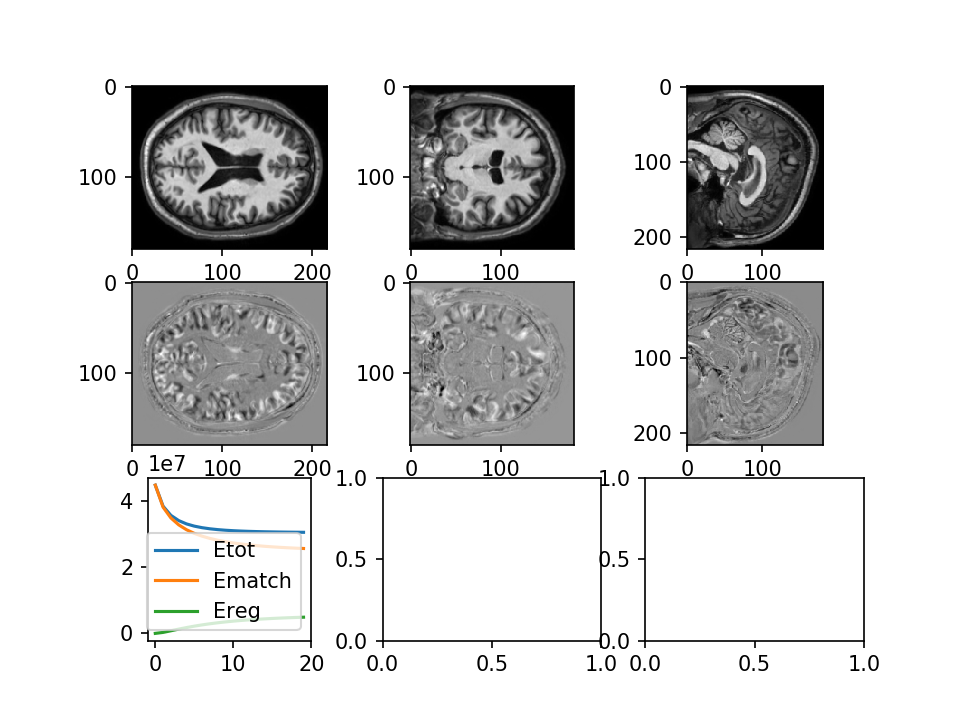

0.0
0.0
59164.75700568146
295823.7850284073
160515.2048609976
786781.4915563165
265506.0962399262
1286748.0579558488
364681.56311141513
1756170.3665702988
455453.2280224807
2183033.8644184787
536981.9771389668
2564193.7646938846
609485.0495711479
2901639.4213555893
730280.9496515268
3461338.2997831553
780378.5792427007
3692339.2624422032
824732.2898601256
3896184.8906700145
864060.5822573312
4076328.9942677664
898981.2796982384
4235767.83167344
930027.7358977539
4377091.644492572
957661.1397395466
4502535.248500756
982283.6290430541
4614014.06210867
1004244.501914036
4713180.789432093
1023853.9931750312
4801498.527167761
1041385.9726560822
4880252.941591111


In [20]:
EMall = []
ERall = []
Eall = []
f,ax = plt.subplots(3,3)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(niter):
        # take a step of gradient descent
        # everything I evaluate should be run at once
        _,EM_,ER_,E_,Idnp,lambda1np = sess.run([step,EM,ER,E,It[-1],lambda1],{epsilonph:epsilon})        
        draw_slices(x, Idnp, ax[0], cmap='gray', aspect='equal')
        draw_slices(x, lambda1np, ax[1], cmap='gray', aspect='equal')
        
        EMall.append(EM_)
        ERall.append(ER_)
        Eall.append(E_)
        ax[2][0].cla()
        ax[2][0].plot(list(zip(Eall,EMall,ERall)))
        xlim = ax[2][0].get_xlim()
        ylim = ax[2][0].get_ylim()
        ax[2][0].set_aspect((xlim[1]-xlim[0])/(ylim[1]-ylim[0]))
        ax[2][0].legend(['Etot','Ematch','Ereg'])
        
        f.canvas.draw()
        f.savefig('lddmm3d_example_iteration_{:03d}.png'.format(i))
    vt0np,vt1np,vt2np = sess.run([vt0new,vt1new,vt2new],{epsilonph:epsilon})
    

<IPython.core.display.Javascript object>


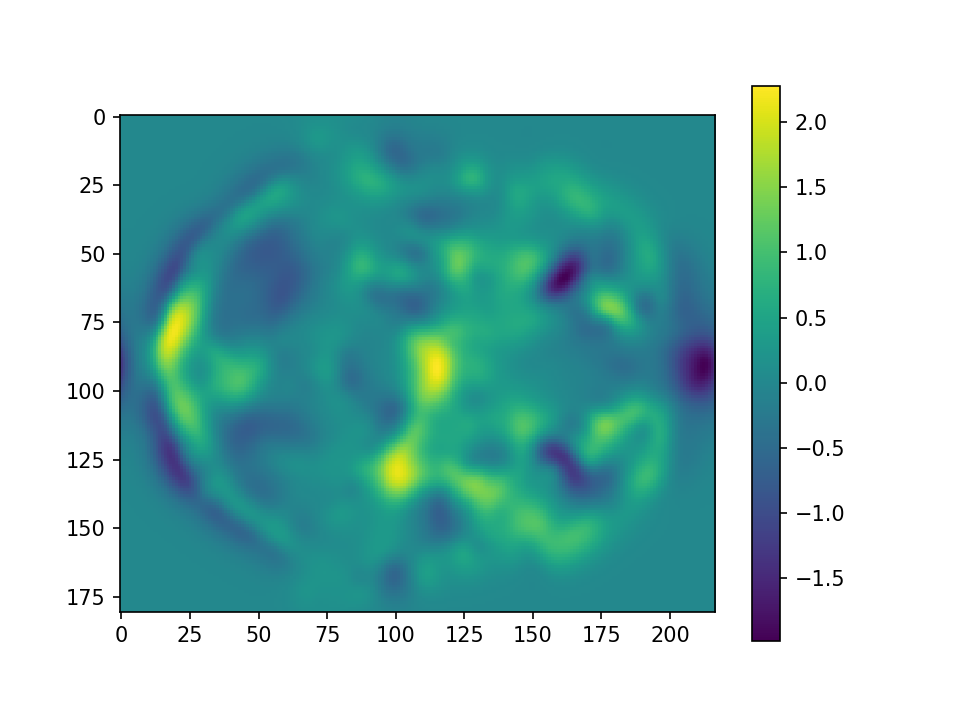

In [21]:
plt.figure()
plt.imshow(np.squeeze(vt1np[:,:,40,0]))
plt.colorbar()

In [22]:
normalizer

0.1

In [23]:
dx

array([1., 1., 1.], dtype=float32)

In [24]:
1.0/nx[0]/nx[1]/nx[2]

1.4066404965891076e-07